In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the data
data = pd.read_csv('../data/crime_data_cleaned.csv')

data.shape

(550307, 29)

### Building a Data Model
We want to build a model that will serve to influence a metric. The metric we are interested in is the clearance rate of crimes. The clearance rate is the percentage of crimes that are "solved" or "cleared" by the police. A crime is considered cleared when an arrest is made, when a suspect is charged, or when the case is closed in some other way. The clearance rate is calculated by dividing the number of crimes that are cleared by the total number of crimes recorded.




<div style="text-align:center">
    <img src="/Users/danherman/Desktop/los_angeles_crime/images/clearance_rate.png" alt="Clearance Rate" width="900" height="600">
</div>





In [9]:
# calculate the clearance rate for each crime category
clearance_rate = data.loc[ 
                          (data['Status']=='AA')| # set boolean mask for AA (Adult Arrest) using OR operator
                          (data['Status']=='JA') # set boolean mask for JA (Juvenile Arrest)
                          ]['crime_category'].value_counts()/data['crime_category'].value_counts().round(2) 
                        # calculate the clearance rate for each crime category counting Arrests and dividing by total crimes

clearance_rate.to_frame().reset_index().rename(columns={'index':'crime_category','count':'clearance_rate'}).sort_values(by='clearance_rate',ascending=False)

,crime_category,clearance_rate
3,CRIMINAL HOMICIDE,0.581064
0,AGGRAVATED ASSAULT,0.232817
7,ROBBERY,0.196637
4,HUMAN TRAFFICKING,0.163082
6,RAPE,0.110393
1,ARSON,0.092247
2,BURGLARY,0.083368
8,THEFT,0.033568
5,MOTOR VEHICLE THEFT,0.029930


### Plot the data

In [ ]:
# set run command for font and font weight
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'

# set the color palette
palette = sns.color_palette("coolwarm", len(clearance_rate))

# create the plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=clearance_rate.index, y=clearance_rate.values, ax=ax, palette=palette)
plt.title('Clearance Rate by Crime Category', fontsize=16)
plt.xlabel('Crime Category')
plt.ylabel('Clearance Rate')

# Rotate and align x-axis labels for readability
for item in ax.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

plt.show()



### Create the target variable
The target variable is arrest. We will create a binary variable that indicates whether an arrest was made or not. We will use the 'Arrest' column to create this variable. We will replace the 'True' values with 1 and the 'False' values with 0. We will then calculate the clearance rate by dividing the number of crimes that were cleared by the total number of crimes recorded.


target
0    505331
1     44976
Name: count, dtype: int64

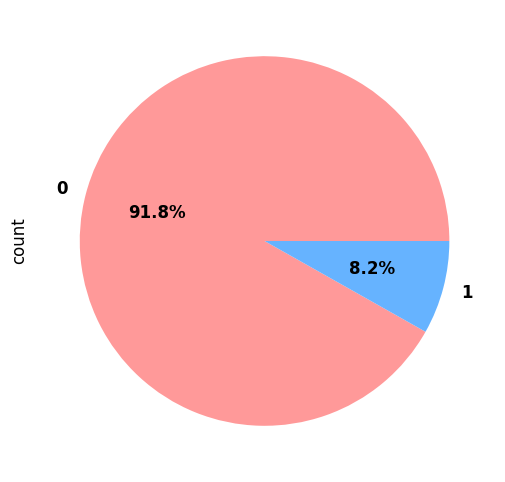

In [30]:
# create target variable - If Arrested Adult Arrest (AA) or Juvenile Arrest (JA) = 1, else 0
data['target'] = data['Status'].apply(lambda x: 1 if x in ['AA', 'JA'] else 0)

display(data['target'].value_counts())
data.target.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6, 6), colors=['#ff9999','#66b3ff']);

### There is a huge class imblance.  There are 55,000 observations of arrest, compared to 505,331 observations of no arrest.  This is a class imbalance of 1:10.  We will need to address this in our model.

### We can go deeper into crimes and look at them individually, by severity.

### First we can look into Homicide

In [21]:
# isolate arrests made for Homicide
data.query('crime_category == "CRIMINAL HOMICIDE"')['target'].value_counts()

target
1    896
0    646
Name: count, dtype: int64

In [23]:
# create a dataframe for criminal homicide 
homicide = data.query('crime_category == "CRIMINAL HOMICIDE"')

In [25]:
homicide.columns

Index(['DR_NO', 'DateRptd', 'DATEOCC', 'TIMEOCC', 'AREA', 'AREANAME',
       'RptDistNo', 'Part1-2', 'CrmCd', 'CrmCdDesc', 'Mocodes', 'VictAge',
       'VictSex', 'VictDescent', 'PremisCd', 'PremisDesc', 'WeaponUsedCd',
       'WeaponDesc', 'Status', 'StatusDesc', 'CrmCd1', 'CrmCd2', 'CrmCd3',
       'CrmCd4', 'LOCATION', 'CrossStreet', 'LAT', 'LON', 'crime_category',
       'target'],
      dtype='object')

In [31]:
# build the model islolating appropriate columns
homicide = homicide.loc[:,['DateRptd', 'DATEOCC', 'TIMEOCC','AREANAME','CrmCdDesc','VictAge','VictSex', 'VictDescent','PremisDesc','WeaponDesc', 'Status','StatusDesc','crime_category','target']]

homicide

,DateRptd,DATEOCC,TIMEOCC,AREANAME,CrmCdDesc,VictAge,VictSex,VictDescent,PremisDesc,WeaponDesc,Status,StatusDesc,crime_category,target
2317,2020-05-16,2020-05-15,1945,Central,CRIMINAL HOMICIDE,57,M,H,STAIRWELL*,UNKNOWN TYPE CUTTING INSTRUMENT,AA,Adult Arrest,CRIMINAL HOMICIDE,1
3181,2020-07-24,2020-07-23,2145,Newton,CRIMINAL HOMICIDE,31,M,A,SIDEWALK,UNKNOWN FIREARM,IC,Invest Cont,CRIMINAL HOMICIDE,0
3961,2020-06-17,2020-06-17,50,77th Street,CRIMINAL HOMICIDE,19,M,B,STREET,UNKNOWN FIREARM,AA,Adult Arrest,CRIMINAL HOMICIDE,1
3989,2020-09-12,2020-09-12,1200,Northeast,CRIMINAL HOMICIDE,37,M,W,STREET,BLUNT INSTRUMENT,AO,Adult Other,CRIMINAL HOMICIDE,0
4284,2020-11-15,2020-11-15,150,Newton,CRIMINAL HOMICIDE,30,F,B,SIDEWALK,UNKNOWN FIREARM,AA,Adult Arrest,CRIMINAL HOMICIDE,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547762,2024-03-12,2024-03-12,1,Southeast,CRIMINAL HOMICIDE,20,F,H,MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV'...,DIRK/DAGGER,IC,Invest Cont,CRIMINAL HOMICIDE,0
547936,2024-01-08,2024-01-08,536,Wilshire,CRIMINAL HOMICIDE,44,M,H,OTHER BUSINESS,SCISSORS,AA,Adult Arrest,CRIMINAL HOMICIDE,1
548250,2024-01-15,2024-01-15,1340,Newton,CRIMINAL HOMICIDE,22,M,H,SHOPPING MALL (COMMON AREA),SEMI-AUTOMATIC PISTOL,JA,Juv Arrest,CRIMINAL HOMICIDE,1
548524,2024-02-21,2024-02-15,150,Southeast,CRIMINAL HOMICIDE,57,F,B,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",UNKNOWN FIREARM,AA,Adult Arrest,CRIMINAL HOMICIDE,1


### We will vectorize the text columns and see if we can extract any words as features in the model

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer



41